# PCA 

### Importing Libraries

In [11]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import  transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from sklearn.decomposition import PCA


from tqdm import tqdm_notebook as tqdm

import os

from os import listdir

### Directories and principale variables

In [12]:
dim = 3
# 3, 20, 90, 373, 1544

In [13]:
base_dir = os.getcwd()

In [14]:
data_dir = os.path.join(base_dir, 'data')
output_dir = os.path.join(base_dir, 'outputs')
processed_data_dir = os.path.join(base_dir, 'processed_data')
file_path = os.path.join(processed_data_dir, 'data_pca_' + str(dim) + '.pth')
files = listdir(data_dir)

print(len(files))

280


In [15]:
train_file_path = os.path.join(processed_data_dir, 'train_df.pkl')
test_file_path =  os.path.join(processed_data_dir, 'test_df.pkl')
dev_file_path =  os.path.join(processed_data_dir, 'dev_df.pkl')

### Importing Data

In [16]:
train_df = pd.read_pickle(train_file_path)
test_df = pd.read_pickle(test_file_path)
dev_df = pd.read_pickle(dev_file_path)

### Useful functions and classes

In [17]:
def my_transform(key="train", plot=False):
    train_sequence = [transforms.Resize((50,50)),
                      transforms.RandomHorizontalFlip(),
                      transforms.RandomVerticalFlip()]
    val_sequence = [transforms.Resize((50,50))]
    if plot==False:
        train_sequence.extend([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        val_sequence.extend([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        
    data_transforms = {'train': transforms.Compose(train_sequence),'val': transforms.Compose(val_sequence)}
    return data_transforms[key]


class BreastCancerDataset(Dataset):
    
    def __init__(self, df, transform=None):
        self.states = df
        self.transform=transform
      
    def __len__(self):
        return len(self.states)
        
    def __getitem__(self, idx):
        patient_id = self.states.patient_id.values[idx]
        x_coord = self.states.x.values[idx]
        y_coord = self.states.y.values[idx]
        image_path = self.states.path.values[idx] 
        image = Image.open(image_path)
        image = image.convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        if "target" in self.states.columns.values:
            target = int(self.states.target.values[idx])
        else:
            target = None
            
        return {"image": image,
                "label": target,
                "patient_id": patient_id,
                "x": x_coord,
                "y": y_coord}

In [18]:
train_dataset = BreastCancerDataset(train_df, transform=my_transform(key="train"))
dev_dataset = BreastCancerDataset(dev_df, transform=my_transform(key="val"))
test_dataset = BreastCancerDataset(test_df, transform=my_transform(key="val"))   


batch_size=32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

dataloaders = {"train": train_loader, "dev": dev_loader, "test": test_loader}
print(len(dataloaders["train"]), len(dataloaders["dev"]), len(dataloaders["test"]))

1273 1273 1489


### Images visualization

Minimo valore di pixel: -1.998030662536621
Massimo valore di pixel: 2.5354249477386475


KeyboardInterrupt: 

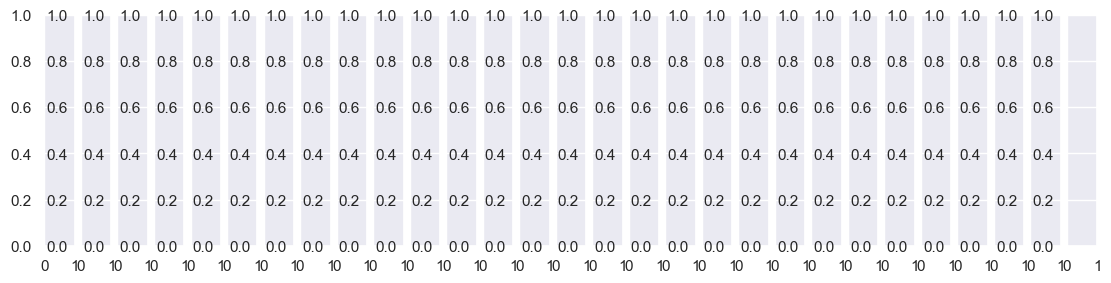

In [19]:

batch = next(iter(train_loader))

batch_images = batch["image"]

min_value = np.min(batch_images.numpy())
max_value = np.max(batch_images.numpy())

print(f"Minimo valore di pixel: {min_value}")
print(f"Massimo valore di pixel: {max_value}")

normalized_images = (batch_images - min_value) / (max_value - min_value)

fig, axes = plt.subplots(1, batch_size, figsize=(15, 3))
for i in range(batch_size):
   image = normalized_images[i].permute(1, 2, 0)
   axes[i].imshow(image)
   axes[i].axis('off')

plt.show()

# PCA

In [ ]:
def extract_data(loader):
    data = []
    labels = []
    for batch in tqdm(loader, desc="Extracting data from DataLoader"):
        images = batch["image"]
        targets = batch["label"]
        data.append(images.view(images.size(0), -1))
        labels.append(targets)
    data = torch.cat(data)
    labels = torch.cat(labels)
    return data, labels

train_data, train_labels = extract_data(train_loader)
dev_data, dev_labels = extract_data(dev_loader)
test_data, test_labels = extract_data(test_loader)

Extracting data from DataLoader:   0%|          | 0/1273 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
def normalize_data(data):
    data = data.numpy().astype(np.float32)
    min_value = np.min(data)
    max_value = np.max(data)
    data = (data - min_value) / (max_value - min_value)
    data = np.clip(data, 0, 1)
    return data

def plot_pca(data_pca, labels, title, ax=None):
   if ax is None:
       plt.figure(figsize=(8, 5))
       ax = plt.gca()
   
   scatter = ax.scatter(data_pca[:, 0], data_pca[:, 1], c=labels, cmap='tab10', alpha=0.5)
   ax.set_xlabel('First Principal Component')
   ax.set_ylabel('Second Principal Component')
   ax.set_title(title)
   plt.colorbar(scatter, ax=ax, ticks=range(10))

In [ ]:
train_data = normalize_data(train_data)
train_labels = train_labels.numpy()

dev_data = normalize_data(dev_data)
dev_labels = dev_labels.numpy()

test_data = normalize_data(test_data)
test_labels = test_labels.numpy()

In [ ]:
pca = PCA(dim)  
train_data_pca = pca.fit_transform(train_data)
dev_data_pca = pca.transform(dev_data)
test_data_pca = pca.transform(test_data)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

plot_pca(train_data_pca, train_labels, 'PCA of BC Train Set', ax=axes[0])
plot_pca(test_data_pca, test_labels, 'PCA of BC Test Set', ax=axes[1])

plt.show()

### Saving Data

In [ ]:
torch.save({'train': train_data_pca, 'test': test_data_pca, 'tr_lab': train_labels, 'te_lab': test_labels}, 'data_pca_3.pth')

## Explained Variance

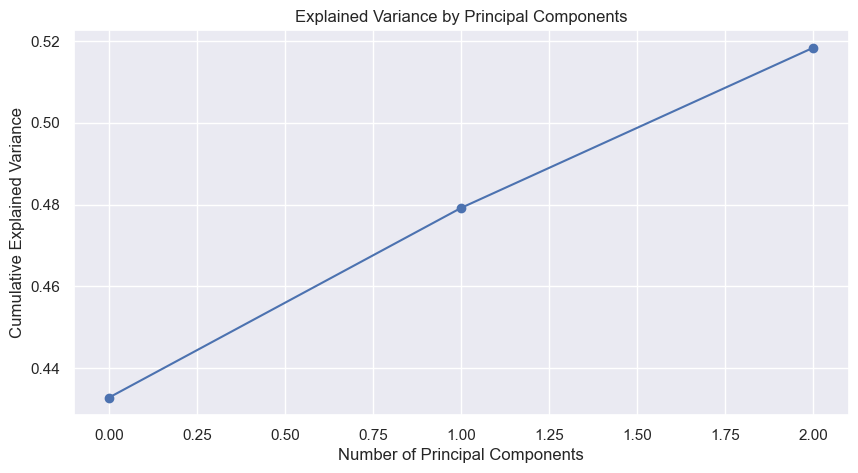

Number of components that explain at least 60.0% of variance: 1


In [ ]:
cumulative_explained_variance = pca.explained_variance_ratio_.cumsum()

In [ ]:
plt.figure(figsize=(10, 5))
title = 'Cumulative_explained_variance'
plt.plot(cumulative_explained_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid(True)
plt.savefig(os.path.join(output_dir, title+'.png'))
plt.show()

In [ ]:
threshold =0.55 #0.65, 0.75, 0.85, 0.95
num_components = (cumulative_explained_variance >= threshold).argmax() + 1
print(f'Number of components that explain at least {threshold*100}% of variance: {num_components}')

# Training PCA

In [ ]:
class FeedforwardNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, out_dim, dropout_prob=0.5):
        super(FeedforwardNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)  # Aggiungi batch normalization 
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)  # Aggiungi dropout
        self.fc2 = nn.Linear(hidden_dim, out_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def train(model, train_loader_pca, loss_function, optimizer):
    model.train()
    total_loss = 0
    for x, y in train_loader_pca:
        optimizer.zero_grad()
        out = model(x)
        loss = loss_function(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader_pca)

def evaluate(model, data_loader_pca):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in data_loader_pca:
            out = model(x)
            _, predicted = torch.max(out.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    return 100 * correct / total

In [ ]:
train_data_pca = torch.tensor(train_data_pca, dtype=torch.float32)
train_targets = torch.tensor(train_labels, dtype=torch.long)
dev_data_pca = torch.tensor(dev_data_pca, dtype=torch.float32)
dev_targets = torch.tensor(dev_labels, dtype=torch.long)
test_data_pca = torch.tensor(test_data_pca, dtype=torch.float32)
test_targets = torch.tensor(test_labels, dtype=torch.long)


batch_size = 32  
train_dataset_pca = torch.utils.data.TensorDataset(train_data_pca, train_targets)
train_loader_pca = torch.utils.data.DataLoader(train_dataset_pca, batch_size=batch_size, shuffle=True, drop_last=True)

dev_dataset_pca = torch.utils.data.TensorDataset(dev_data_pca, dev_targets)
dev_loader_pca = torch.utils.data.DataLoader(dev_dataset_pca, batch_size=batch_size, shuffle=True, drop_last=True)


test_dataset_pca = torch.utils.data.TensorDataset(test_data_pca, test_targets)
test_loader_pca = torch.utils.data.DataLoader(test_dataset_pca, batch_size=batch_size, shuffle=False)


input_dim = train_data_pca.shape[1]  
print(f"Input dimension: {input_dim}")

In [ ]:
hidden_dim = 100 
out_dim = 2  
dropout_prob = 0.5  
model = FeedforwardNetwork(input_dim, hidden_dim, out_dim, dropout_prob)


loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0005) 

In [ ]:
num_epochs = 100

train_losses_pca = []
train_accuracies_pca = []
test_accuracies_pca = []

for epoch in range(num_epochs):
    train_loss_pca = train(model, train_loader_pca, loss_function, optimizer)
    train_losses_pca.append(train_loss_pca)

    train_accuracy = evaluate(model, train_loader_pca)
    train_accuracies_pca.append(train_accuracy)

    test_accuracy = evaluate(model, test_loader_pca)
    test_accuracies_pca.append(test_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss_pca:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')

### Plots

In [ ]:
title = 'PCA_losses'
epoche = [i for i in range(num_epochs)]
plt.plot(epoche, train_losses_pca, label = "Train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig(os.path.join(output_dir, title+'.png'))
plt.show()

In [ ]:
title = 'PCA_accuracies'
epoche = [i for i in range(num_epochs)]
plt.plot(epoche, train_accuracies_pca, label = "Train")
plt.plot(epoche, test_accuracies_pca, label = "Test")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(os.path.join(output_dir, title+'.png'))
plt.show()

### Best Weight Decay

In [ ]:
weight_decay_values = [0.0005]
#0.00001, 0.0001, 0.00015 ,0.0005 ,0.0009, 0.001, 0.003, 0.005, 0.006, 0.008, 0.009

In [ ]:
def train_and_evaluate_with_weight_decay(weight_decay, num_epochs=num_epochs):
    model = FeedforwardNetwork(input_dim, hidden_dim, out_dim, dropout_prob)
    optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=weight_decay)

    train_losses = []
    dev_accuracies = []

    for epoch in range(num_epochs):
        print(f'processing epoch {epoch}...')
        train_loss = train(model, train_loader_pca, loss_function, optimizer)
        train_losses.append(train_loss)

        dev_accuracy = evaluate(model, dev_loader_pca)
        dev_accuracies.append(dev_accuracy)
        

    return train_losses, dev_accuracies


In [ ]:
results = {}

for wd in weight_decay_values:
    print(f'Training with weight decay: {wd}')
    train_losses, dev_accuracies = train_and_evaluate_with_weight_decay(wd)
    results[wd] = (train_losses, dev_accuracies)

In [ ]:
plt.figure(figsize=(12, 5))
title = 'PCA'


plt.subplot(1, 2, 1)
for wd, (train_losses, dev_accuracies) in results.items():
    plt.plot(train_losses, label=f'weight_decay={wd}')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.title('Training Loss vs. Epochs')


plt.subplot(1, 2, 2)
for wd, (train_losses, dev_accuracies) in results.items():
    plt.plot(dev_accuracies, label=f'weight_decay={wd}')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.title('Validation Accuracy vs. Epochs')

plt.savefig(os.path.join(output_dir, title+'.png'))
plt.tight_layout()
plt.show()

